In [ ]:
#To install the necessary packages, please run this cell:
!pip install -r pip_requirements.txt


In [2]:
# import libraries 
import pandas as pd
import matplotlib.pyplot as plt
import sys
from pathlib import Path
import seaborn as sns

# Add 'src' to the system path
sys.path.append(str(Path().resolve() / 'src'))
from src.data.process_data import create_cmu_tmdb_dataset
from src.utils.data_utils import *
from src.utils.plot_utils import *
from src.models.empath_model import *
import json

IMPORTANT: these scripts/functions assume you have the following files in the data/raw directory:
- From the CMU dataset: 
    - movie.metadata.tsv
    - plot_summaries.txt
- From the TMDB dataset: 
    - TMDB_movie_dataset_v11.csv

AND have data/processed folder created

Note: download CMU dataset [here](https://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz)
and TMDB dataset [here (Download button)](https://www.kaggle.com/datasets/asaniczka/tmdb-movies-dataset-2023-930k-movies)

In [3]:
# from clean data files, creates a dataframe with TMDB movies 
df = create_cmu_tmdb_dataset(cmu_movies_path='data/processed/movies.csv', plots_path='data/processed/plot_summaries.csv', 
                             tmdb_path='data/processed/TMDB_clean.csv', how_merge='inner')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17027 entries, 0 to 17026
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   title                 17027 non-null  object
 1   release_year          17027 non-null  int64 
 2   summary               17027 non-null  object
 3   release_date          17027 non-null  object
 4   budget                17027 non-null  int64 
 5   original_language     17027 non-null  object
 6   overview              17027 non-null  object
 7   genres                17027 non-null  object
 8   production_companies  17027 non-null  object
 9   production_countries  17027 non-null  object
 10  spoken_languages      17027 non-null  object
 11  keywords              17027 non-null  object
 12  revenue               17027 non-null  int64 
 13  runtime               17027 non-null  int64 
 14  dvd_era               17027 non-null  object
dtypes: int64(4), object(11)
memory usage

In [3]:
df.head()

,title,release_year,summary,release_date,budget,original_language,overview,genres,production_companies,production_countries,spoken_languages,keywords,revenue,runtime,dvd_era
0,White Of The Eye,1987,A series of murders of rich young women throug...,1987-06-19,0,en,A series of murders of rich young women throug...,"[horror, thriller]",[mrs. white's productions],[united kingdom],[english],"[based on novel or book, gas station, psychopa...",0,221,pre
1,A Woman in Flames,1983,"Eva, an upper class housewife, becomes frustra...",1983-05-11,0,de,"Eva, an upper class housewife, becomes frustra...",[drama],[dieter geissler filmproduktion],[germany],[german],"[jealousy, eroticism, gigolo, longing, dominat...",0,212,pre
2,The Sorcerer's Apprentice,2002,"Every hundred years, the evil Morgana returns...",2002-04-12,0,en,"Every hundred years, the evil Morgana returns...","[adventure, family, fantasy]","[peakviewing productions, peakviewing transatl...",[united kingdom],"[french, english]",[morgana],0,172,during
3,Little city,1997,"Adam, a San Francisco-based artist who works a...",1997-04-04,0,en,"Adam, a San Francisco-based artist who works a...","[comedy, romance]","[bandeira entertainment, miramax]",[],[english],[],0,183,during
4,Henry V,1989,{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...,1989-10-05,9000000,en,{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...,"[war, drama, history]","[bbc film, renaissance films, samuel goldwyn c...",[united kingdom],[english],"[france, kingdom, theater play, based on true ...",20337800,274,pre


In [4]:
df.describe()

,release_year,budget,revenue,runtime
count,17027.000000,1.702700e+04,1.702700e+04,17027.000000
mean,1998.568215,8.202439e+06,4.133476e+07,208.106184
std,9.757122,2.217654e+07,1.565962e+08,46.779799
min,1976.000000,0.000000e+00,0.000000e+00,49.000000
25%,1991.000000,0.000000e+00,0.000000e+00,180.000000
50%,2001.000000,0.000000e+00,0.000000e+00,198.000000
75%,2007.000000,4.500000e+06,1.149728e+07,226.000000
max,2013.000000,3.790000e+08,5.705981e+09,718.000000


Again, we see that not all movies have revenue, runtime, or budget information as they are set to zero. However, we keep these movies in our dataset as they might be associated other relevant information. For any analysis pertaining to these features, we ensure instead to exclude any movies for which their value is 0. 

Our analyses for the CMU dataset follow the analyses for the TMDB dataset, but are more restricted due to the lack of data. 

# General Overview

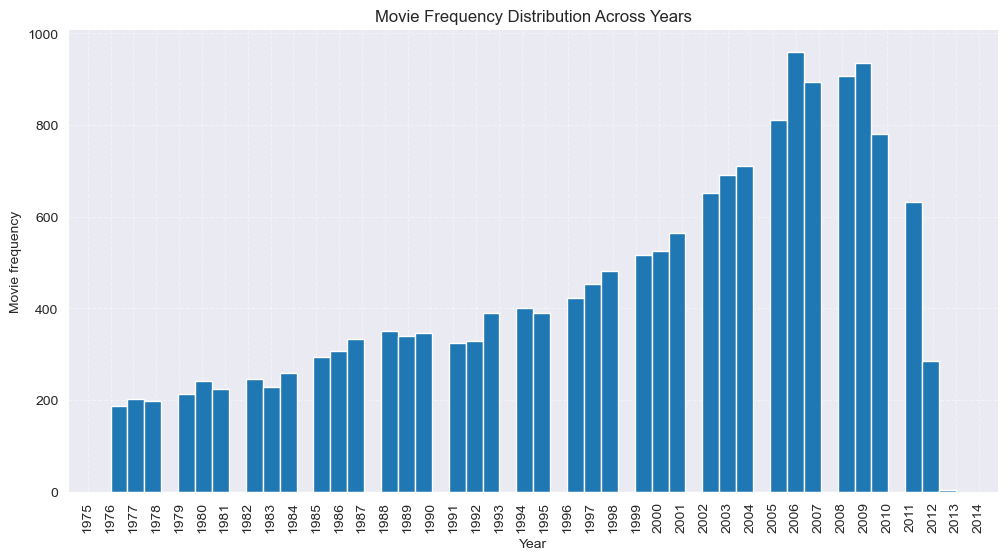

In [5]:
# Get a general distribution of movies
plt.figure(figsize=(12, 6))

plt.hist(df['release_year'], bins=50)
plt.locator_params(axis='x', nbins=50) 
plt.xticks(rotation=90)
style_plot('Movie Frequency Distribution Across Years', 'Year', 'Movie frequency')

In [6]:
print(df.groupby('dvd_era').size().reindex(['pre', 'during', 'post']))


dvd_era
pre        6226
during    10798
post          3
dtype: int64


As we can see, there are almost no movies from 2013 on, which we have determined to the end of the DVD era. As a result, our analyses for the CMU dataset will focus on comparing pre- vs during-DVD eras. We will thus remove the 3 movies released in the post-DVD era from our dataset. 

In [4]:
df = df[df.dvd_era != 'post']

# Revenue overview
We first obtain an overview of movie revenues, considering all movies together.

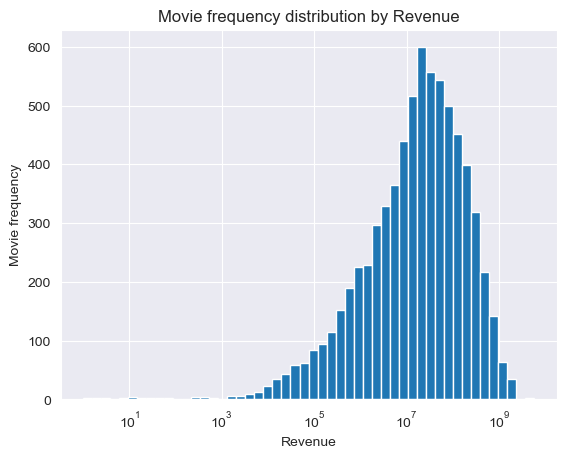

In [10]:
# Frequency distribution per budget, with budget in logscale 
plot_loghist(df[df['revenue'] > 0]['revenue'], 50, xlabel='Revenue', ylabel='Movie frequency')

We then analyse revenue by DVD eras.

In [12]:
# Summary statistics for each DVD era
print('Summary statistics of revenue for each DVD era:')
df[df.revenue > 0].groupby('dvd_era')['revenue'].describe().reindex(['pre', 'during']).transpose()

Summary statistics of revenue for each DVD era:


dvd_era,pre,during
count,2.728000e+03,4.424000e+03
mean,6.668486e+07,1.178951e+08
std,1.422847e+08,2.680085e+08
min,1.000000e+00,1.000000e+00
25%,4.558000e+06,2.428254e+06
50%,1.946512e+07,2.123290e+07
75%,5.952072e+07,1.140698e+08
max,1.834791e+09,5.705981e+09


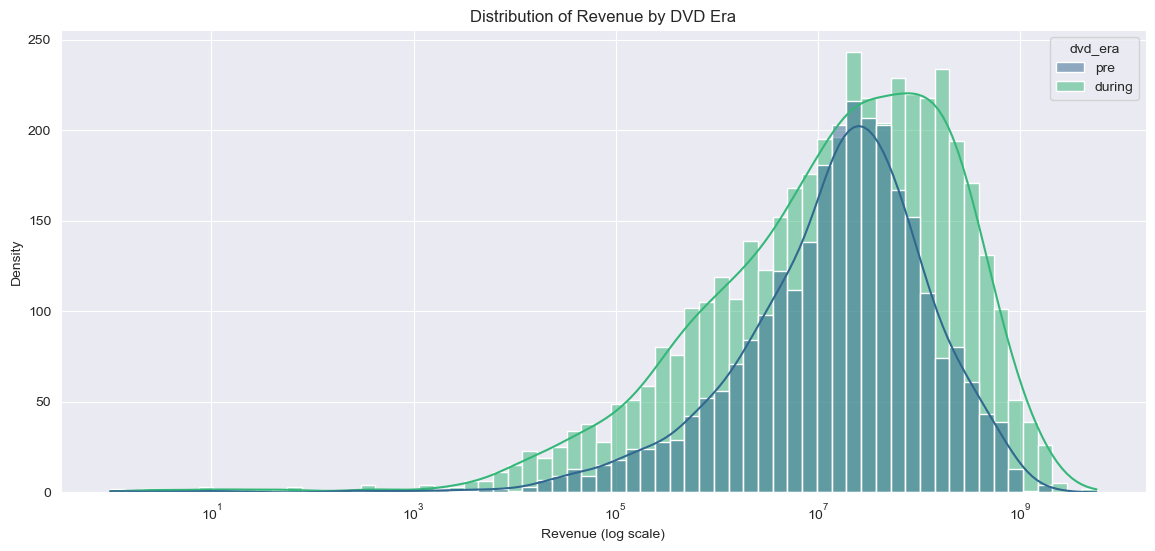

In [13]:
# Revenue per era
plot_revenue_per_era(df)

# Budget overview
We then consider budget distributions.

In [14]:
df_filtered = df[(df['budget'] > 0)]

print('Summary statistics of budget for each DVD era:')
df_filtered.groupby('dvd_era')['budget'].describe().reindex(['pre', 'during']).transpose()

Summary statistics of budget for each DVD era:


dvd_era,pre,during
count,1.922000e+03,4.008000e+03
mean,1.535958e+07,2.743309e+07
std,1.622706e+07,3.713846e+07
min,1.000000e+00,1.000000e+00
25%,4.000000e+06,3.500000e+06
50%,1.000000e+07,1.300000e+07
75%,2.200000e+07,3.500000e+07
max,1.750000e+08,3.790000e+08




We examine the budget trends in more details using plots. 

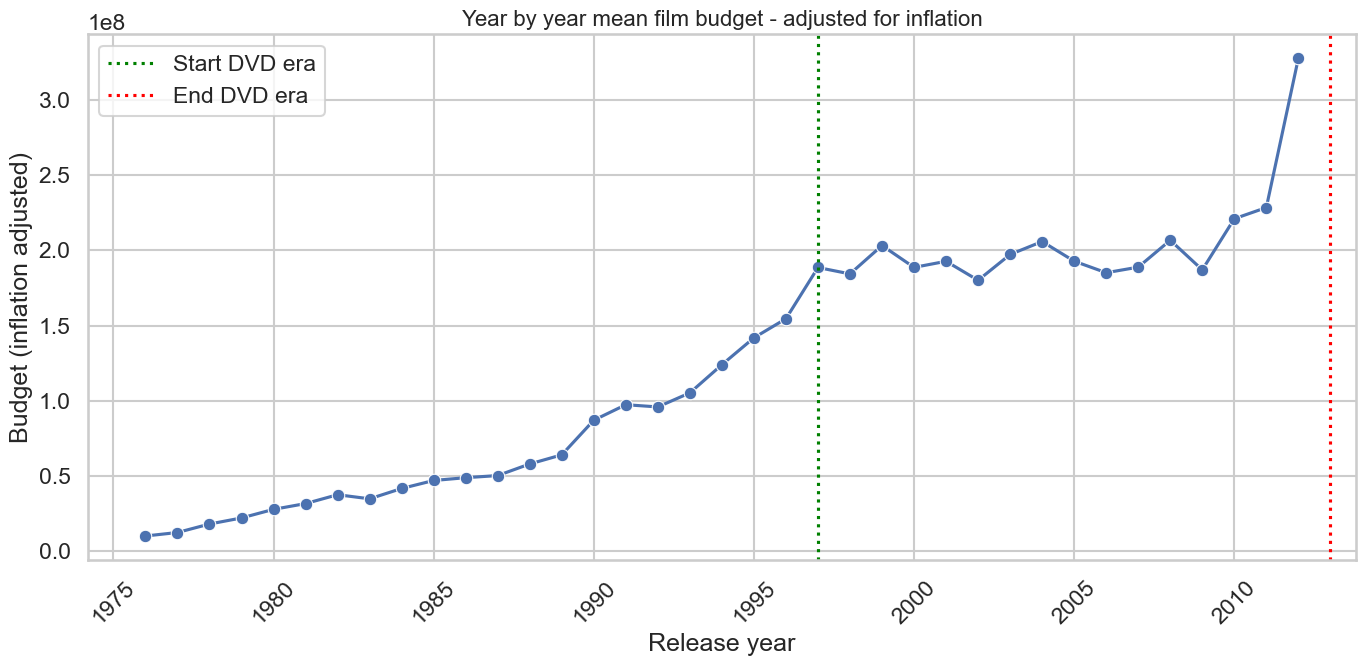

In [15]:
# Plot mean budget across time, accounting for inflation
plot_mean_budget_inflation(df)

We plot the density of revenue pre-DVD and during-DVD eras, using logscale. 

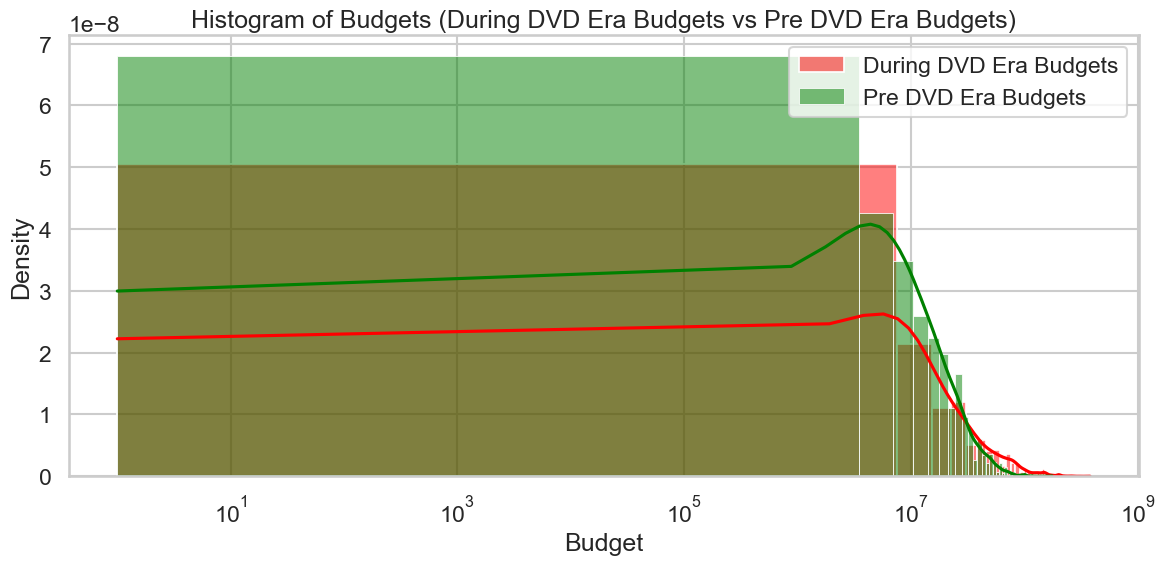

In [44]:
df_filtered = df[(df['budget'] > 0)]

# Define eras, colors, and labels for the plots
eras = [("during", "pre")]
colors = [('red', 'green')]
labels = [('During DVD Era Budgets', 'Pre DVD Era Budgets')]

# Plot histograms
plot_budget_histograms(df_filtered, eras, colors, labels, 'Histogram of Budgets')

## Production types
We again categorize the movies in different types according to their budgets (compared to the mean) :
- Independent movies: less than 1/10th of the mean budget.
- Small productions: Between 1/10th and 1 of the mean budget.
- Big productions: Between 1 and 5 times the mean budget.
- Super productions More than 5 times the mean budget.

We then plot the proportion of those movies (over the total) using a 3 years rolling average.

/Users/chsce/Documents/ada-2024-project-databand/src/utils/data_utils.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'budget_category'] = df.apply(categorize_budget, args=(budget_stats,), axis=1)


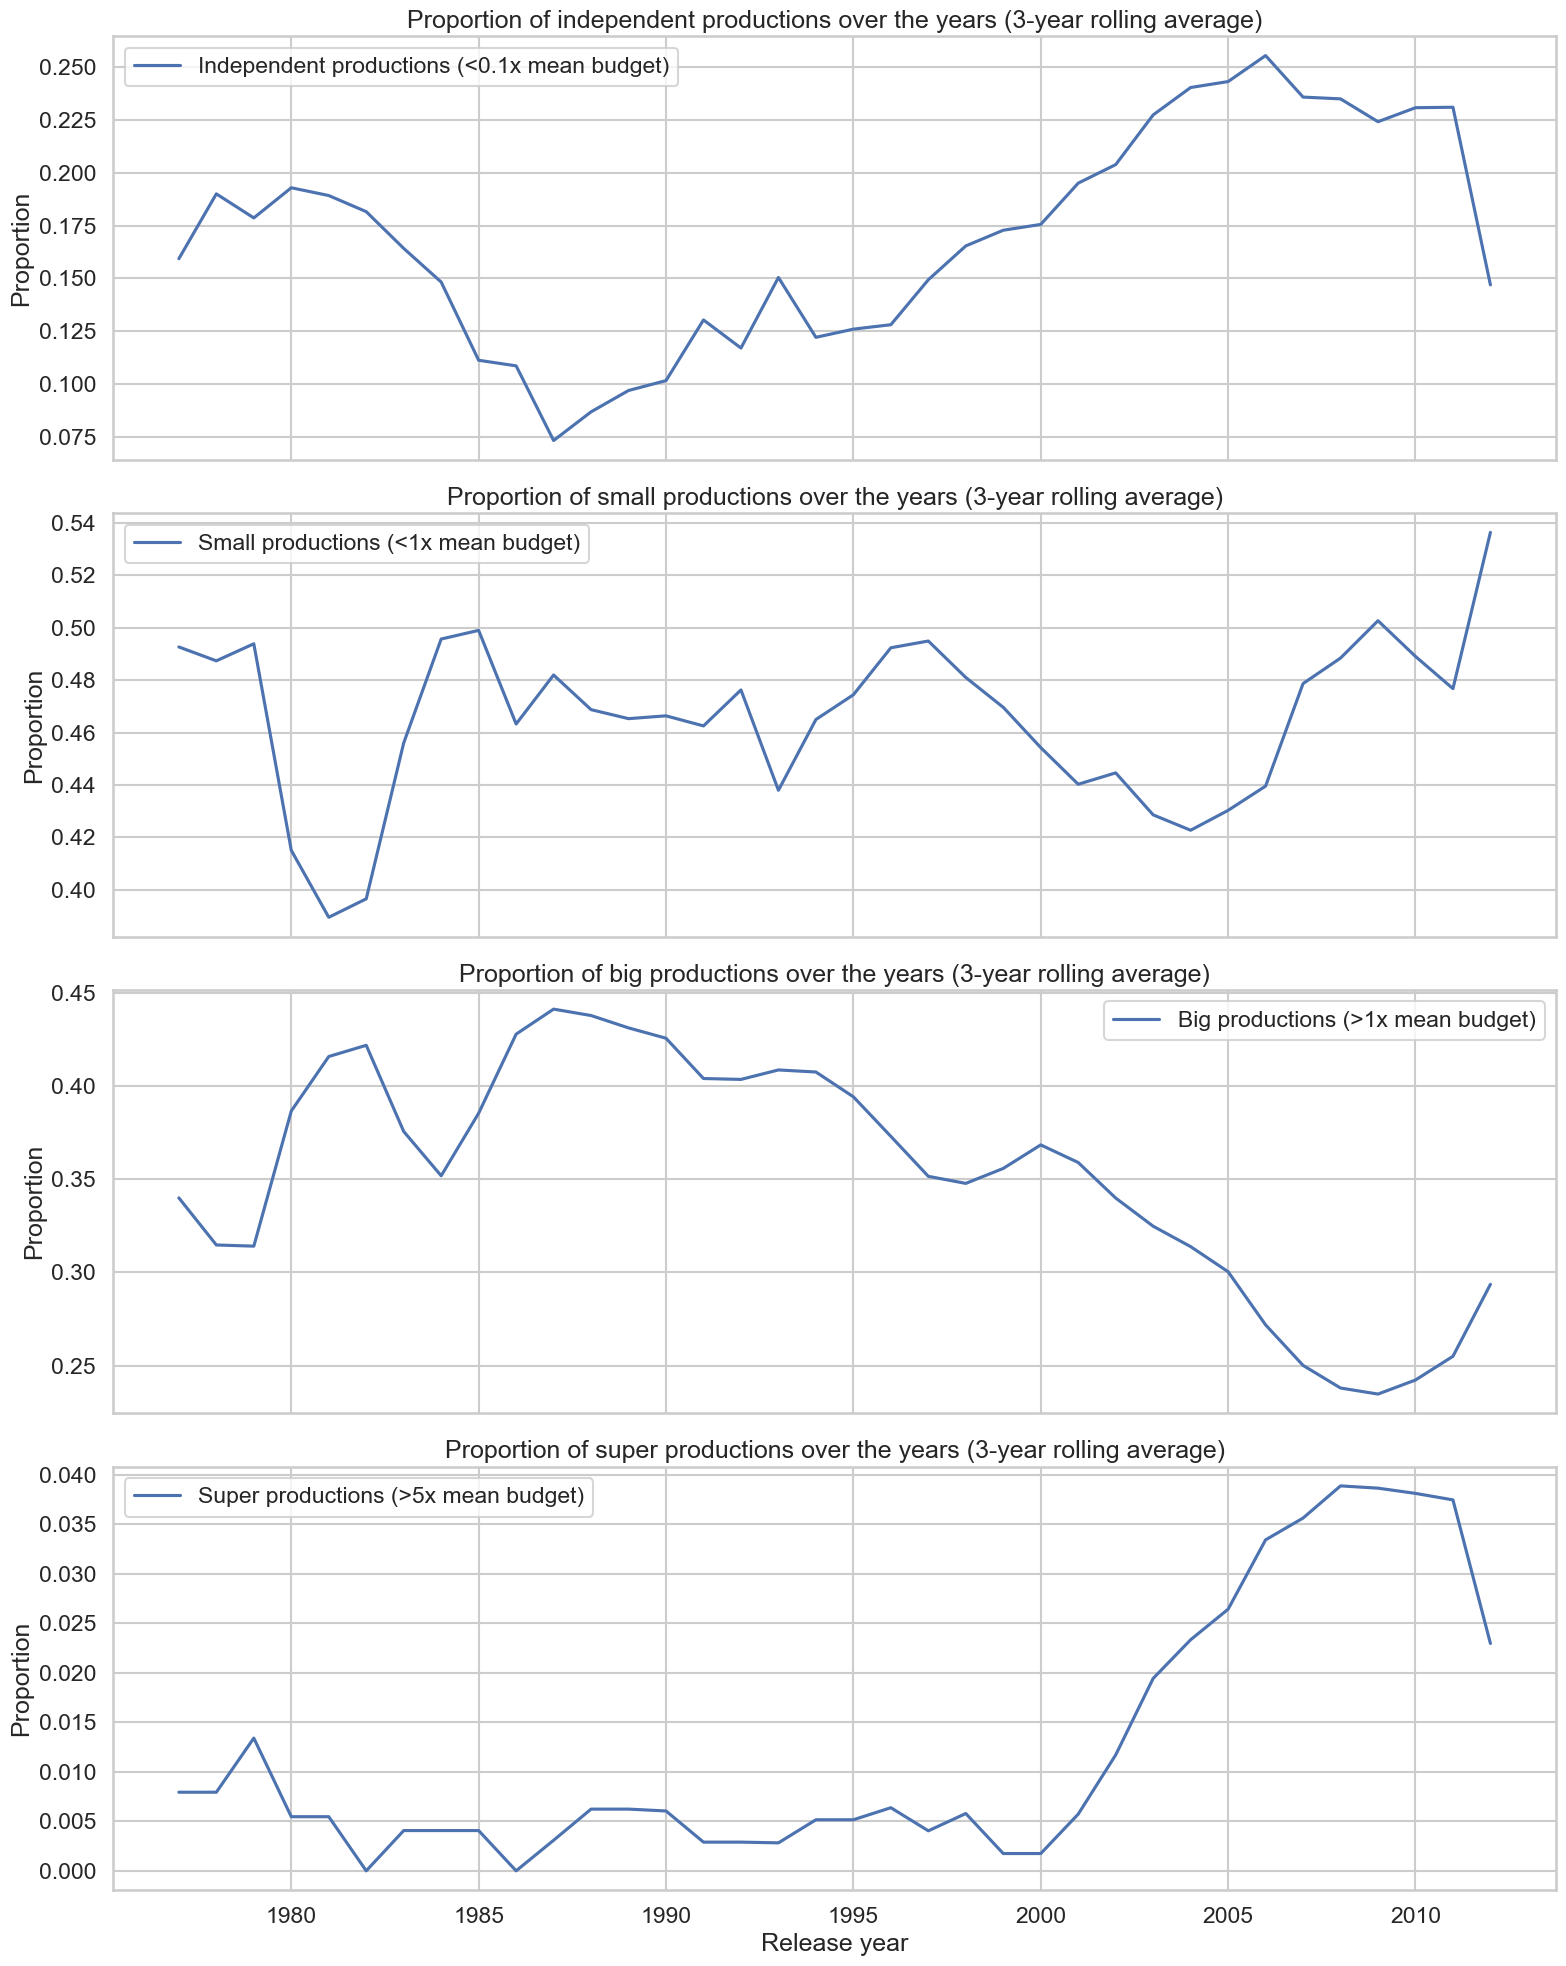

In [45]:
prop_rolling_avg = budget_rolling_averages(df_filtered, window=3)
plot_rolling_averages(prop_rolling_avg)

In [5]:
mean_budgets = df[df.budget > 0].groupby('release_year').agg(mean_budget=('budget', 'mean'))
df['prod_type'] = df.apply(categorize_production, axis=1, args=(mean_budgets,))
df = df[df['dvd_era'].isin(['pre', 'during'])]
df['dvd_era'] = pd.Categorical(df['dvd_era'], categories=['pre', 'during'], ordered=True)
df['prod_type'] = pd.Categorical(df['prod_type'], categories=['Independent', 'Small', 'Big', 'Super'], ordered=True)


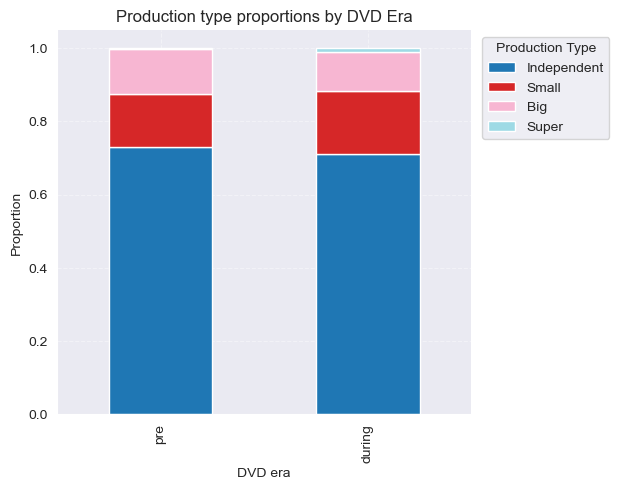

In [6]:
prod_type_proportions = get_proportions(df, base_vars=['dvd_era'], target_var='prod_type')
prod_type_proportions.to_csv('data/website_data/CMU/prod_type_proportions.csv', index=False)
prod_type_proportions.pivot_table(index='dvd_era', columns='prod_type', values='prop', fill_value=0,
                                  observed=False).plot(kind='bar', stacked=True, colormap='tab20')
plt.legend(title="Production Type", bbox_to_anchor=(1.35, 1), loc='upper right')
plt.tight_layout()
style_plot("Production type proportions by DVD Era", "DVD era", "Proportion")

# Production Companies

We then take a look at production companies

In [18]:
# Get number of production companies for each movie 
num_production_companies = df['production_companies'].str.len()

# Get most common number of production companies with their counts 
company_counts = num_production_companies.value_counts().sort_index()
company_counts.head()

production_companies
0    2748
1    4917
2    3885
3    2518
4    1274
Name: count, dtype: int64

Notice, there many movies with no production companies, we will make sure to exclude these for this part of the analysis.

In [19]:
print(f"Movies with single production company: {company_counts.get(1, 0):,} ({company_counts.get(1, 0)/company_counts.sum()*100:.1f}%)")
print(f"Movies with multiple production companies: {company_counts[company_counts.index > 1].sum():,} ({company_counts[company_counts.index > 1].sum()/company_counts.sum()*100:.1f}%)")

Movies with single production company: 4,917 (28.9%)
Movies with multiple production companies: 9,359 (55.0%)


We have similar results than with the TMDB dataset, with a majority of movies having multiple production companies. 
Considering movies that have > 0 production companies, we plot the frequency distribution. 

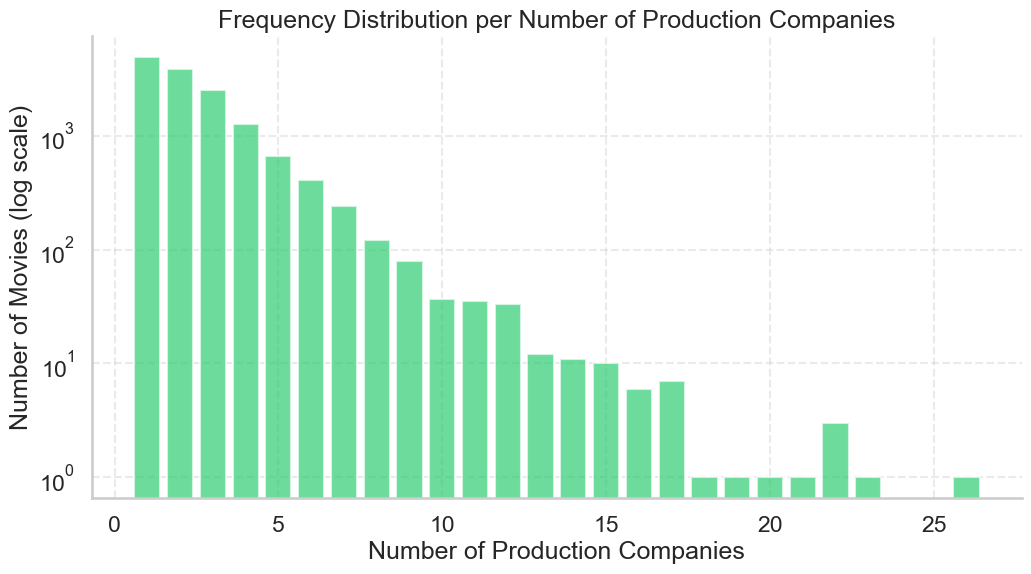

In [20]:
company_counts = company_counts[company_counts.index > 0]
plt.figure(figsize=(12, 6))
plt.bar(company_counts.index, company_counts.values, color='#2ecc71', alpha=0.7, edgecolor='white')

plt.yscale('log')
style_plot('Frequency Distribution per Number of Production Companies', 'Number of Production Companies', 'Number of Movies (log scale)', False)

Interestingly, there are a high number of movies with more than one production company. Production companies have the ressources (creative or financial) to make the movies possible. It would be interesting to see how the number of production companies per movie has evolved over time. 

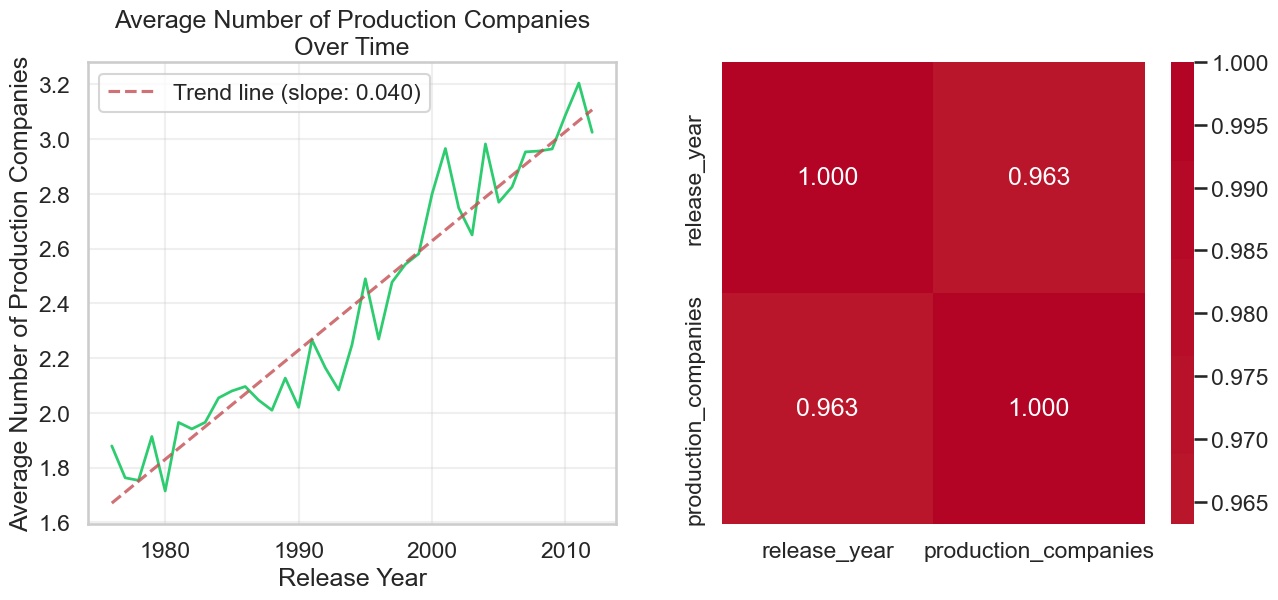

In [21]:
yearly_avg_companies = (df[df['production_companies'].str.len() > 0].groupby('release_year')
                       .agg({'production_companies': lambda x: x.str.len().mean()})
                       .reset_index())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(yearly_avg_companies['release_year'], 
             yearly_avg_companies['production_companies'],
             linewidth=2,
             color='#2ecc71')
z = np.polyfit(yearly_avg_companies['release_year'], 
               yearly_avg_companies['production_companies'], 1)
p = np.poly1d(z)
ax1.plot(yearly_avg_companies['release_year'], 
         p(yearly_avg_companies['release_year']), 
         "r--", 
         alpha=0.8,
             label=f'Trend line (slope: {z[0]:.3f})')

ax1.set_title('Average Number of Production Companies\nOver Time')
ax1.set_xlabel('Release Year')
ax1.set_ylabel('Average Number of Production Companies')
ax1.grid(True, alpha=0.3)
ax1.legend()
    
correlation = yearly_avg_companies['release_year'].corr(yearly_avg_companies['production_companies'])
covariance = yearly_avg_companies['release_year'].cov(yearly_avg_companies['production_companies'])

sns.heatmap(yearly_avg_companies.corr(), 
                annot=True, 
                cmap='coolwarm', 
                center=0,
                fmt='.3f',
                ax=ax2)
plt.show()


From this initial analysis, there is an even stronger correlation between the number of production companies per movie and the release year than TMDB. 


In [22]:
print(df['production_companies'].explode().value_counts().describe())

count    12785.000000
mean         2.858037
std         12.000487
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        567.000000
Name: count, dtype: float64


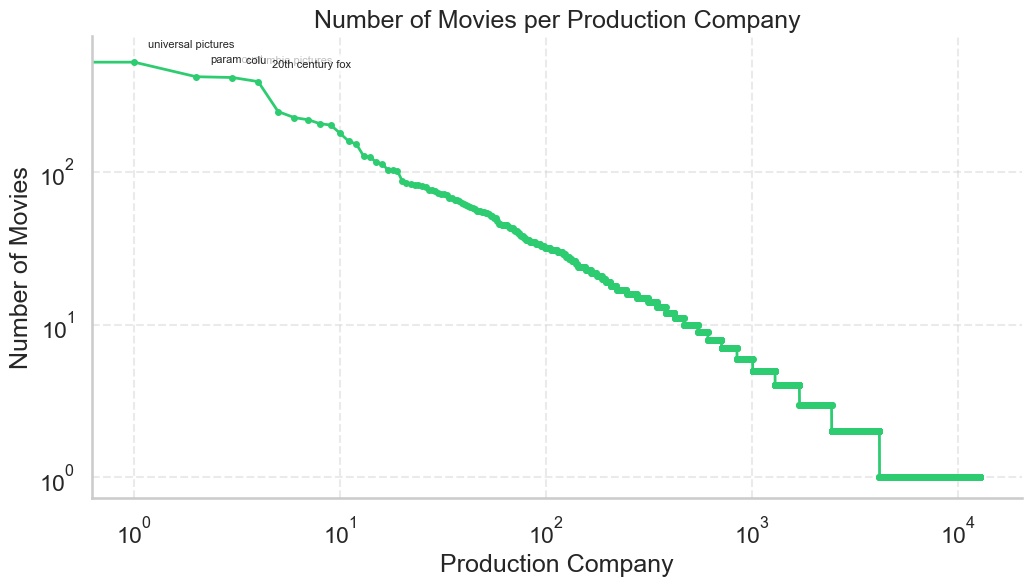

In [23]:
plot_movie_freq_per_production_company(df)

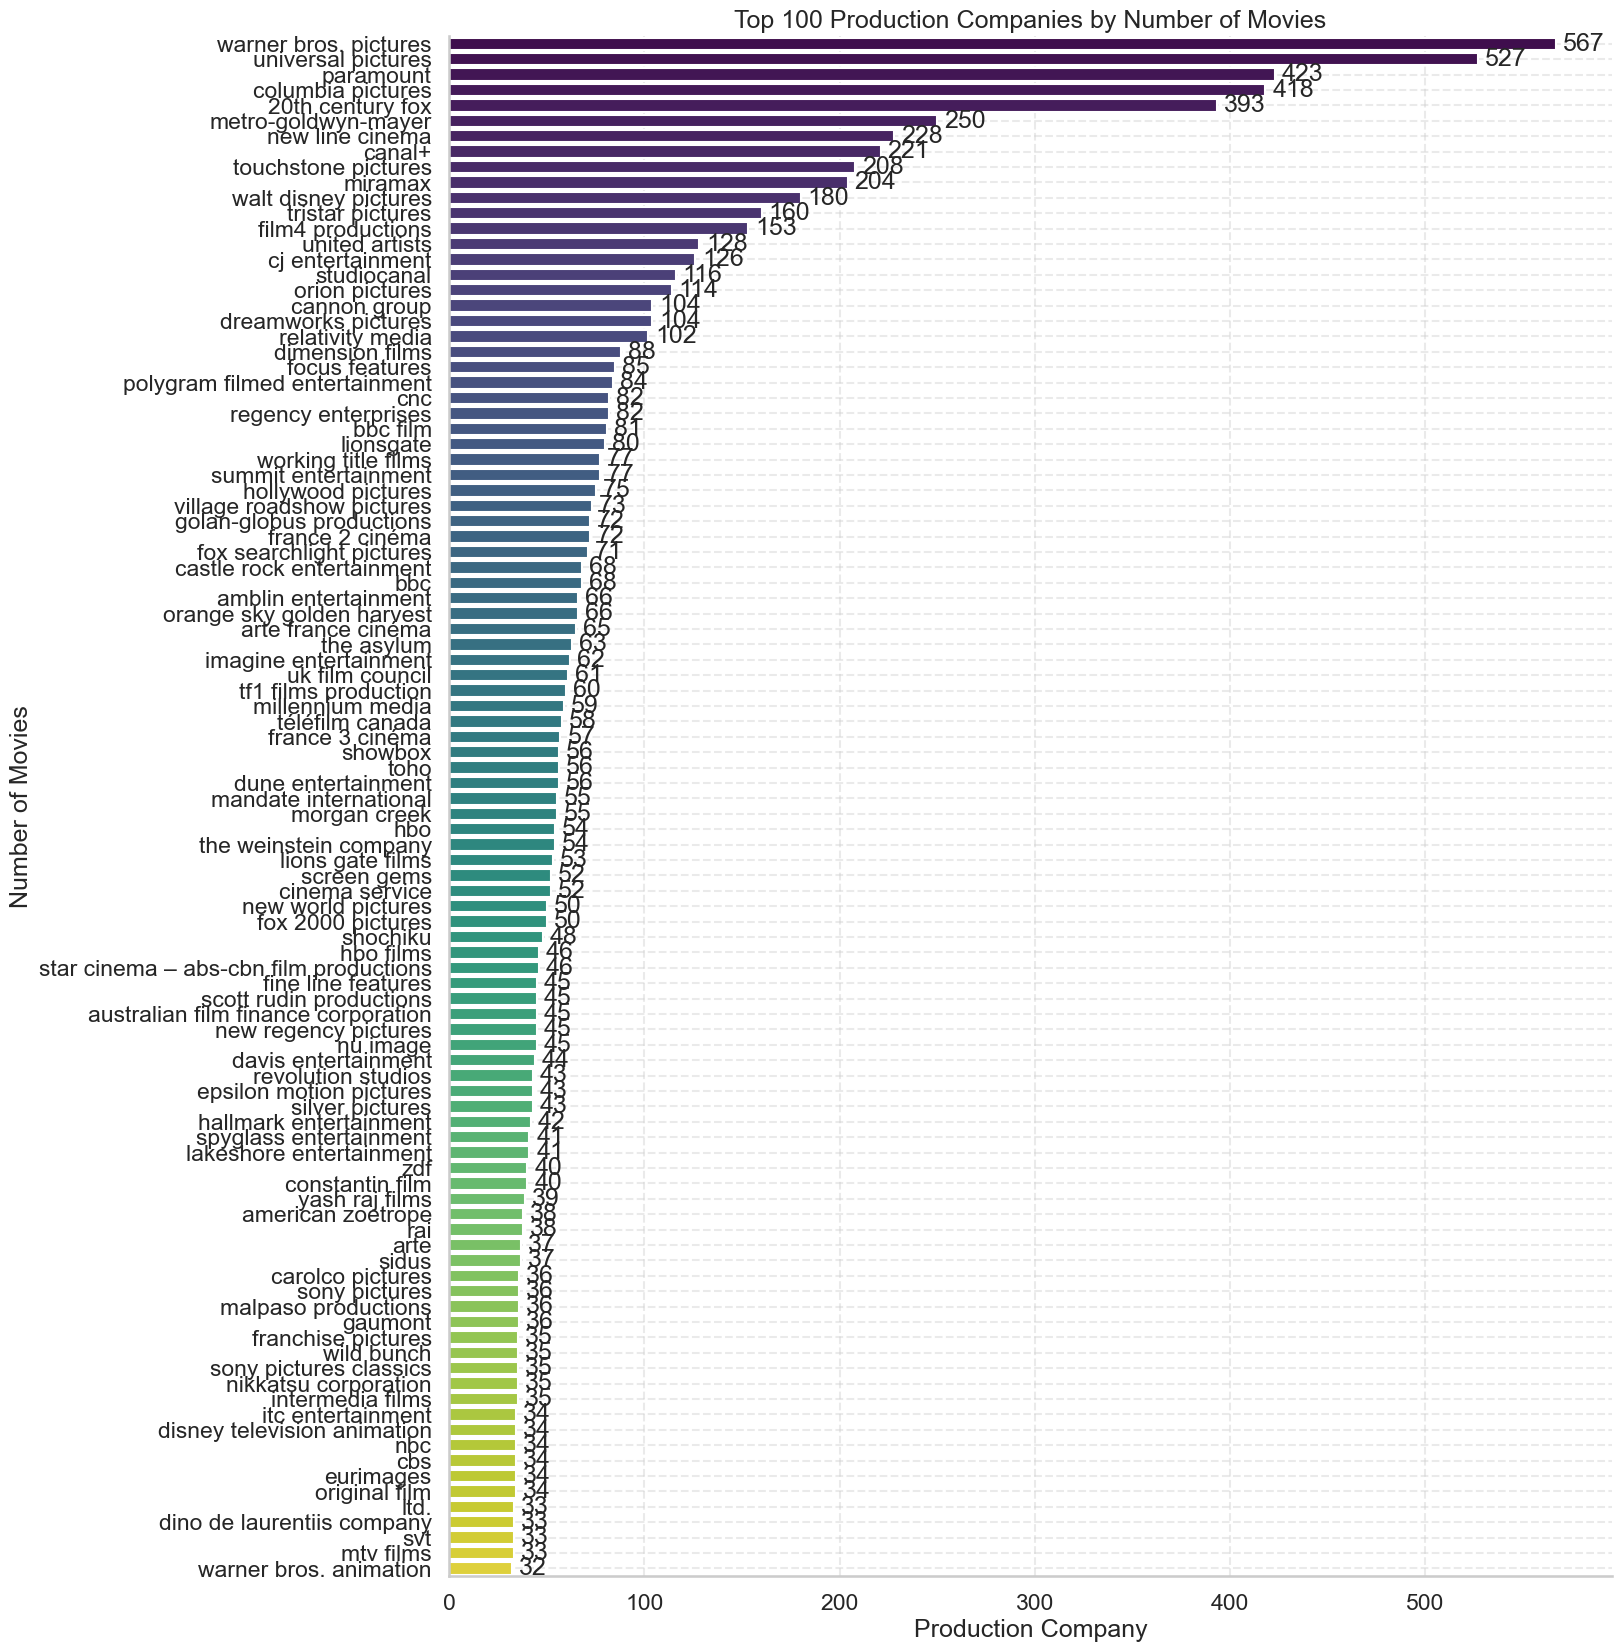

In [24]:
top_100_companies = df['production_companies'].explode().value_counts().head(100)
plt.figure(figsize=(15, 20))

ax = sns.barplot(
    y=top_100_companies.index,
    x=top_100_companies.values,
    palette='viridis',
    hue=top_100_companies.index,
    legend=False
)
for i in ax.containers:
    ax.bar_label(i, padding=5)
ax.grid(axis='x', linestyle='--', alpha=0.7)
style_plot('Top 100 Production Companies by Number of Movies', 'Production Company', 'Number of Movies', False)


There are some production companies that have a very high number of movies for P3 it would be interesting to find out why they are so successful 

# Runtime overview

We get an overview of the movie runtimes, excluding movies that do not have a runtime associated

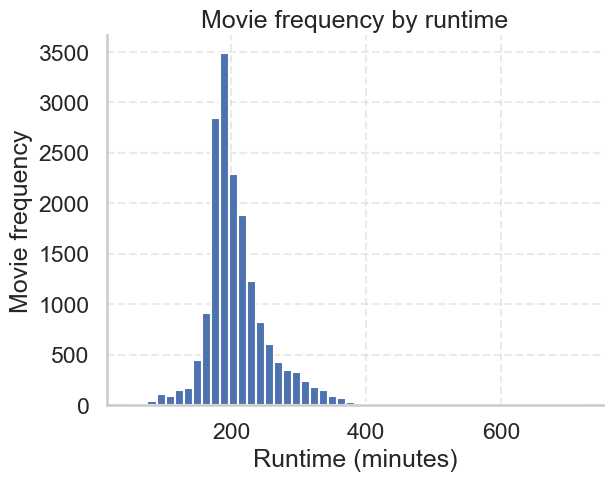

In [25]:
# General runtime distribution
plt.hist(df[(df['runtime'] > 0)]['runtime'], bins=50)
style_plot(title='Movie frequency by runtime', xlabel='Runtime (minutes)', ylabel='Movie frequency')

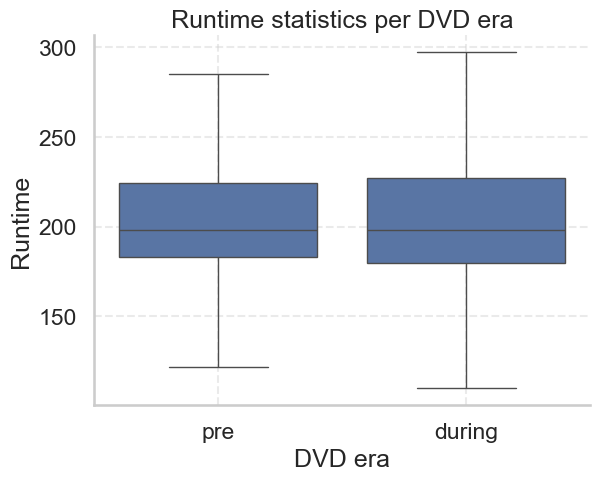

In [29]:
# Runtime statistics in boxplot 
sns.boxplot(x='dvd_era', y='runtime', data=df[df['runtime'] > 0], showfliers=False, order=['pre', 'during'])
style_plot(title='Runtime statistics per DVD era', xlabel='DVD era', ylabel='Runtime')

In [30]:
df[df.runtime >0].groupby('dvd_era')['runtime'].describe().reindex(['pre', 'during']).transpose()

dvd_era,pre,during
count,6226.000000,10798.000000
mean,209.156119,207.505094
std,46.891837,46.711604
min,79.000000,49.000000
25%,183.000000,180.000000
50%,198.000000,198.000000
75%,224.000000,227.000000
max,718.000000,567.000000


There does not seem to be considerable differences in runtime statistics across the DVD eras. 

# Genre overview


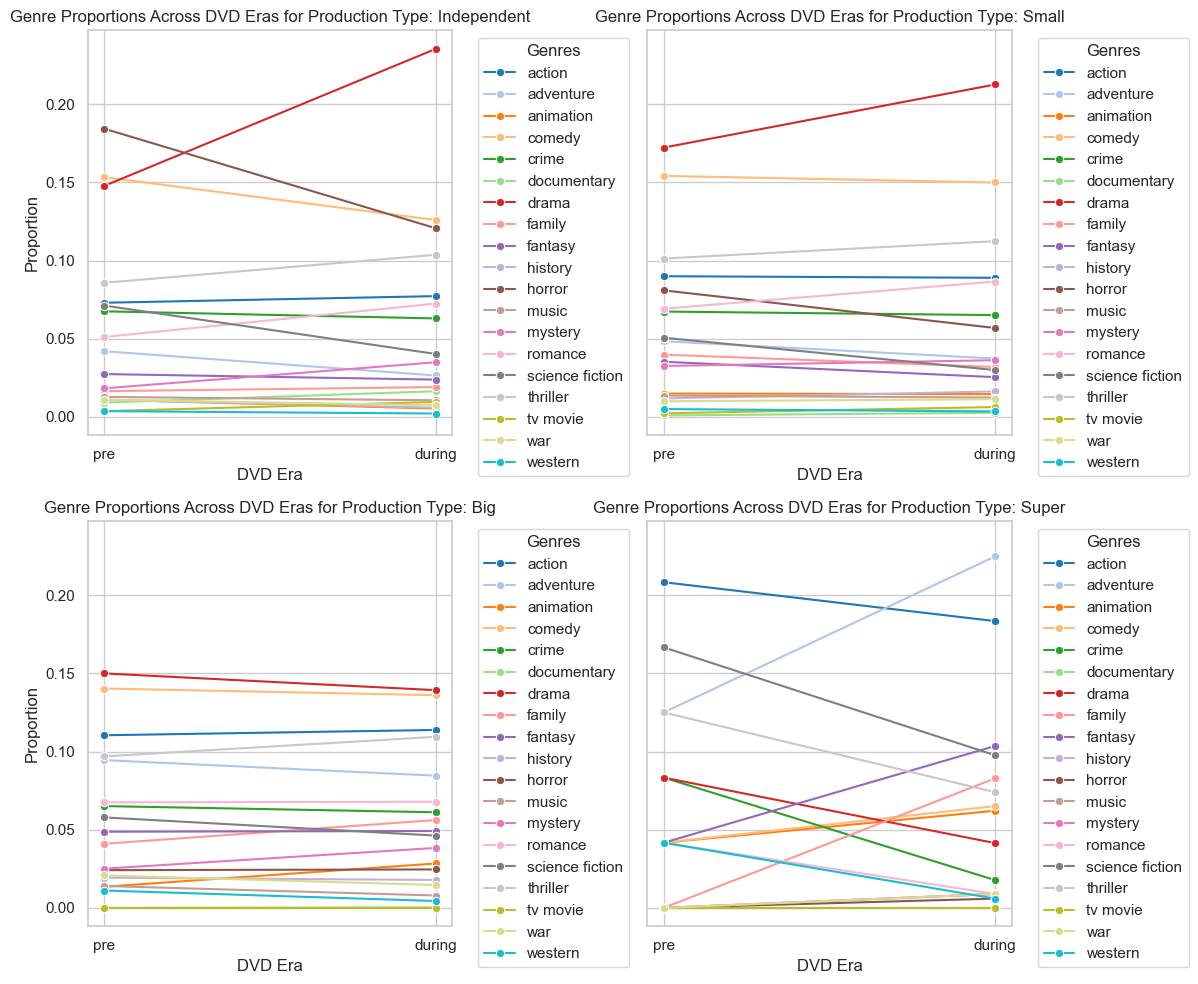

In [7]:
df_genres = df[df.genres.apply(lambda x: len(x) > 0)].copy()
df_genres = df_genres.explode('genres')
df_genres.head()
df_genres = df_genres[df_genres.budget > 0]
genre_proportions = get_proportions(df_genres, base_vars=['prod_type', 'dvd_era'], target_var='genres')

sns.set(style="whitegrid")
f, axs = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
# Loop through each production type
for i, prod_type in enumerate(genre_proportions['prod_type'].unique()):
    subset = genre_proportions[genre_proportions['prod_type'] == prod_type]

    ax = axs.flatten()[i]
    sns.lineplot(data=subset, x='dvd_era', y='prop', hue='genres', marker='o', ax=ax, palette='tab20')
    ax.set_title(f"Genre Proportions Across DVD Eras for Production Type: {prod_type}")
    ax.set_xlabel('DVD Era')
    ax.set_ylabel('Proportion')

    ax.legend(title='Genres', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

plt.show()

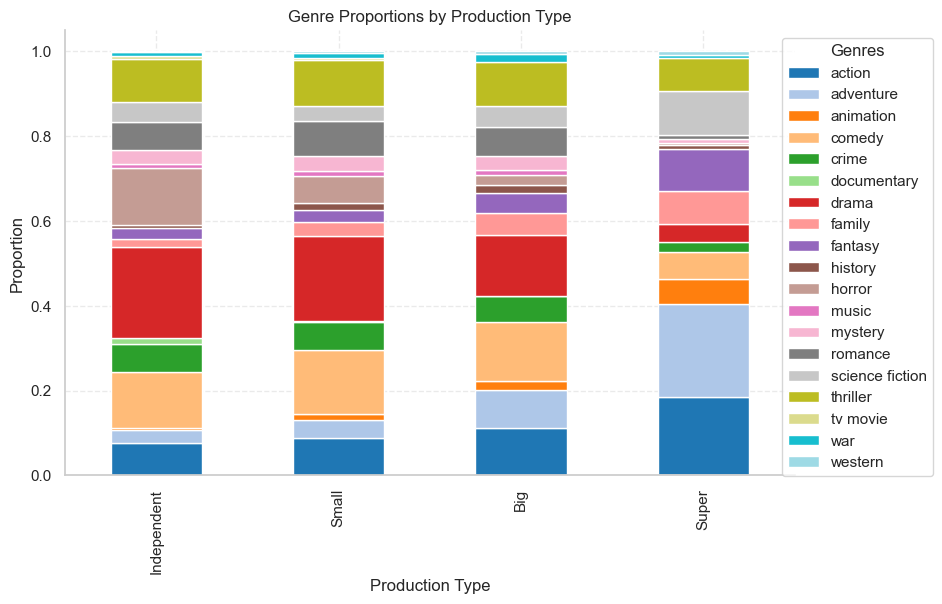

In [8]:
grouped_genres = genre_proportions.groupby(['prod_type', 'genres'], observed=False).sum('count').reset_index()
grouped_genres['proportion'] = grouped_genres['count'] / grouped_genres['total']
# Pivot the DataFrame
pivot_df = grouped_genres.pivot_table(index='prod_type', columns='genres', values='proportion', fill_value=0,
                                      observed=False)

pivot_df.plot(kind='bar', stacked=True, figsize=(8, 6), colormap='tab20')
plt.tight_layout()
plt.legend(title="Genres", bbox_to_anchor=(1.2, 1), loc='upper right')
style_plot("Genre Proportions by Production Type", "Production Type", "Proportion")

# Theme extraction

In [10]:
df_genres['clean_overview'] = df_genres.overview.apply(clean_text)
empathModel = EmpathModel()
selected_genres = ['drama', 'comedy', 'action', 'adventure']
prod_types = ['Independent', 'Small', 'Big', 'Super']
# Run the follow to obtain the results:
# results = empathModel.get_features_genres_prods(df_genres, selected_genres, prod_types)

In [11]:
results = pd.read_csv('data/website_data/CMU/topics_per_genre_prod.csv')

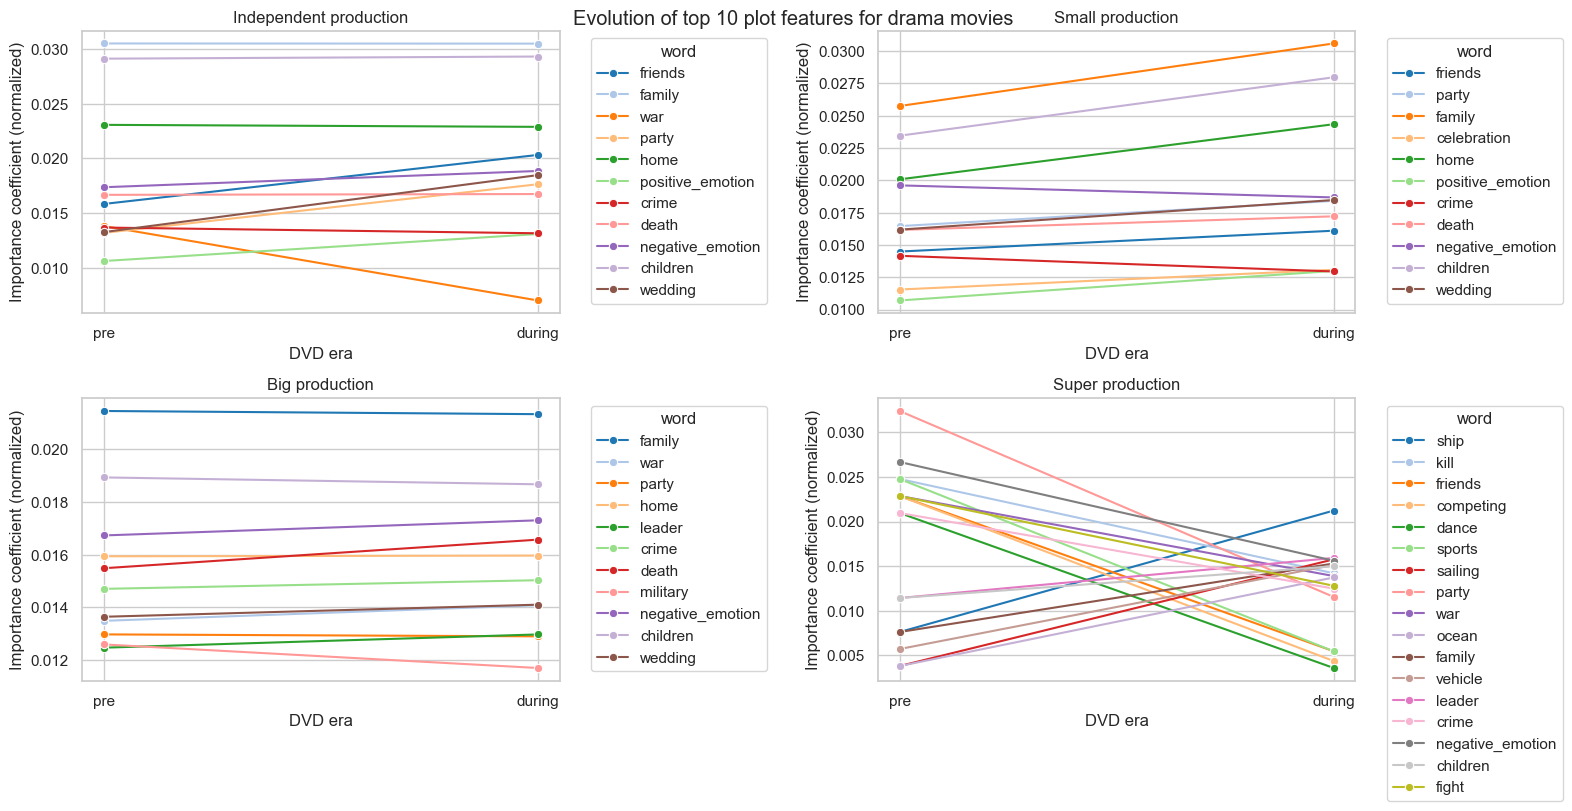

In [12]:
empathModel.plot_all_features(results, 'drama')

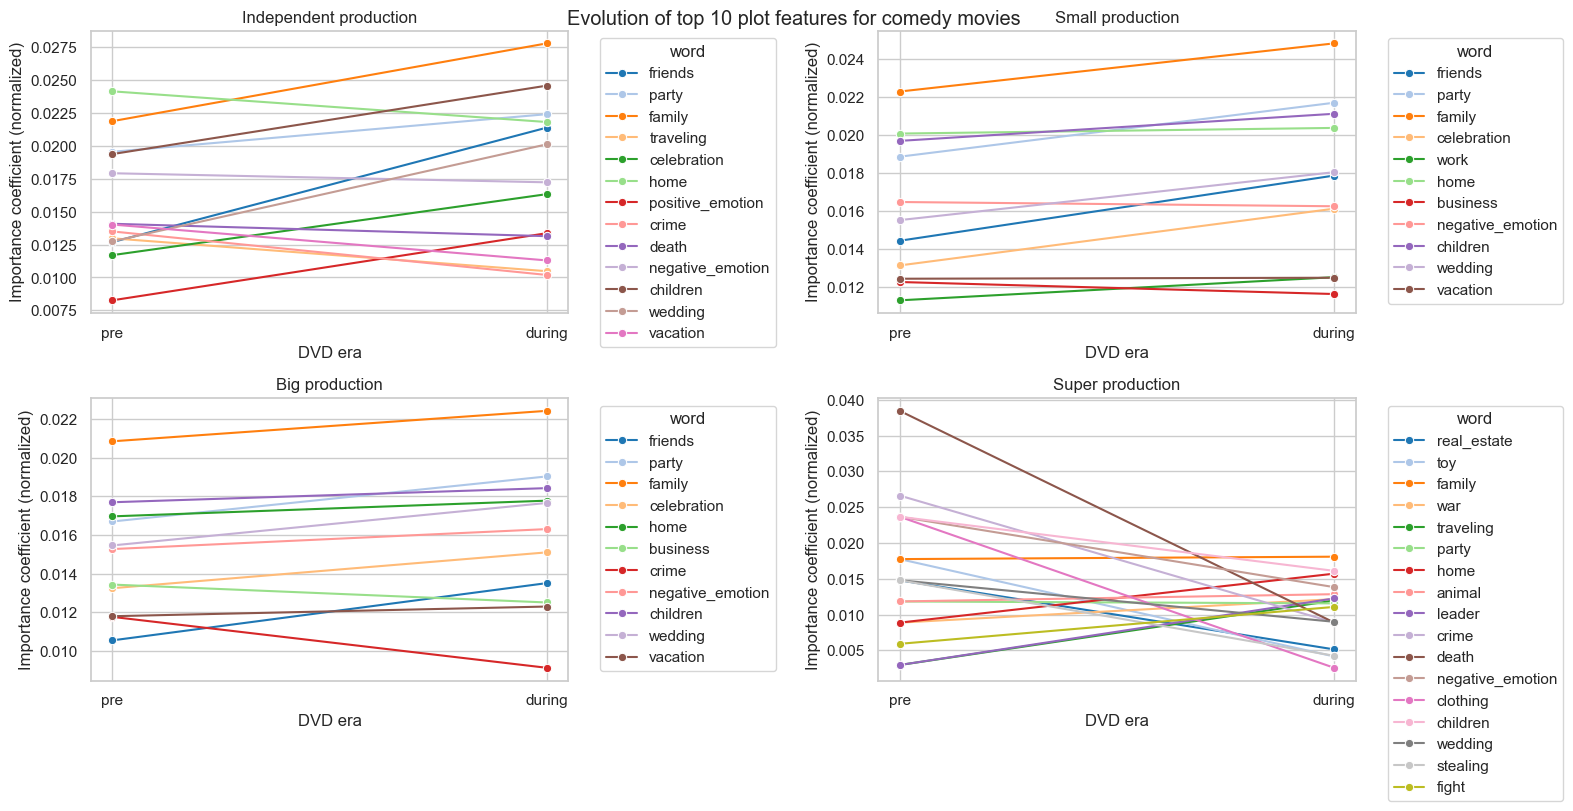

In [13]:
empathModel.plot_all_features(results, 'comedy')


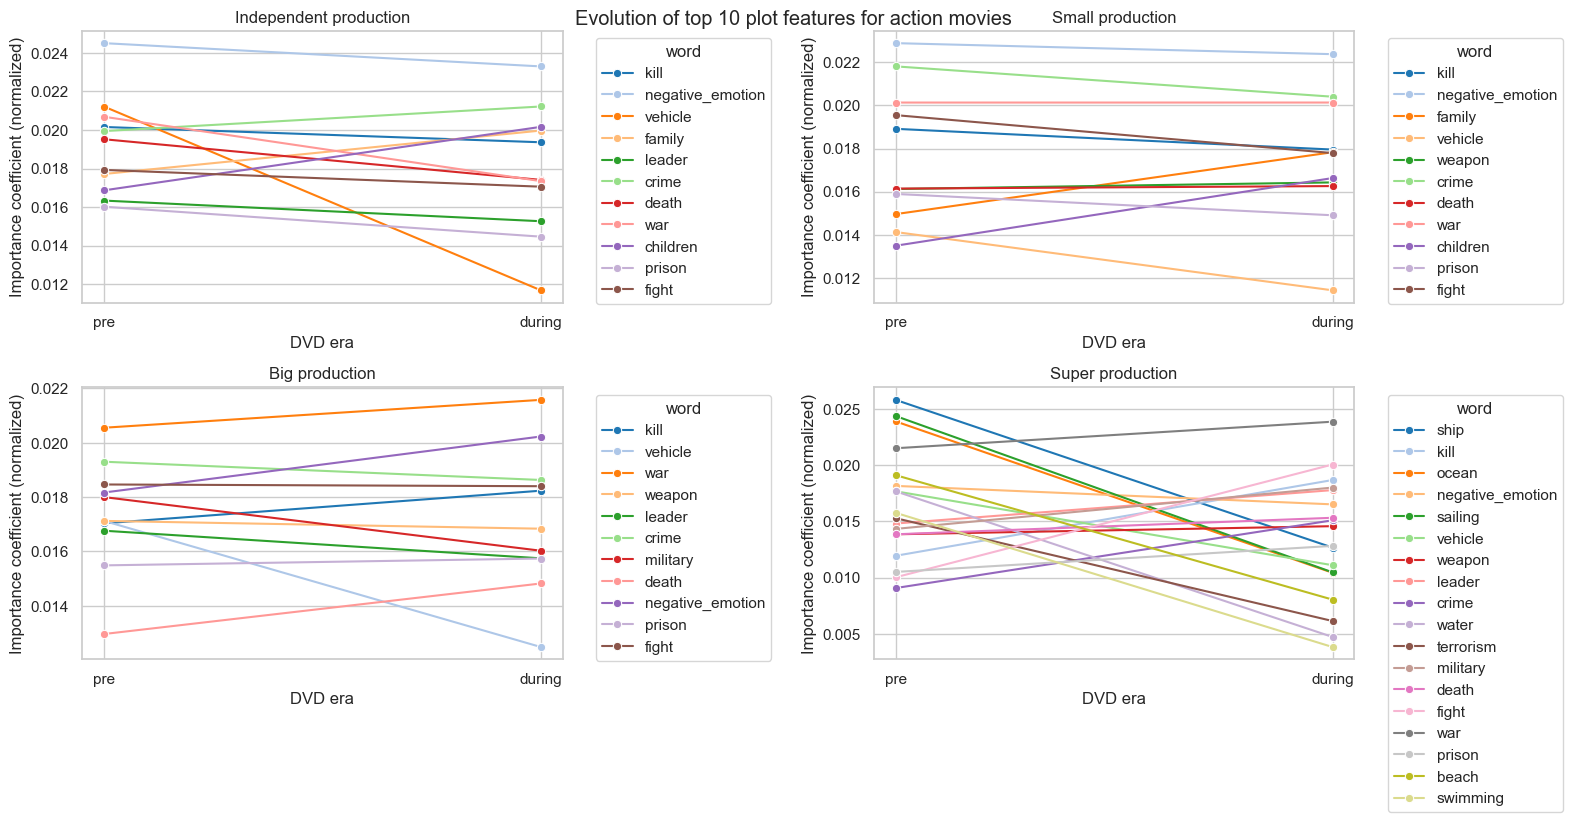

In [14]:
empathModel.plot_all_features(results, 'action')


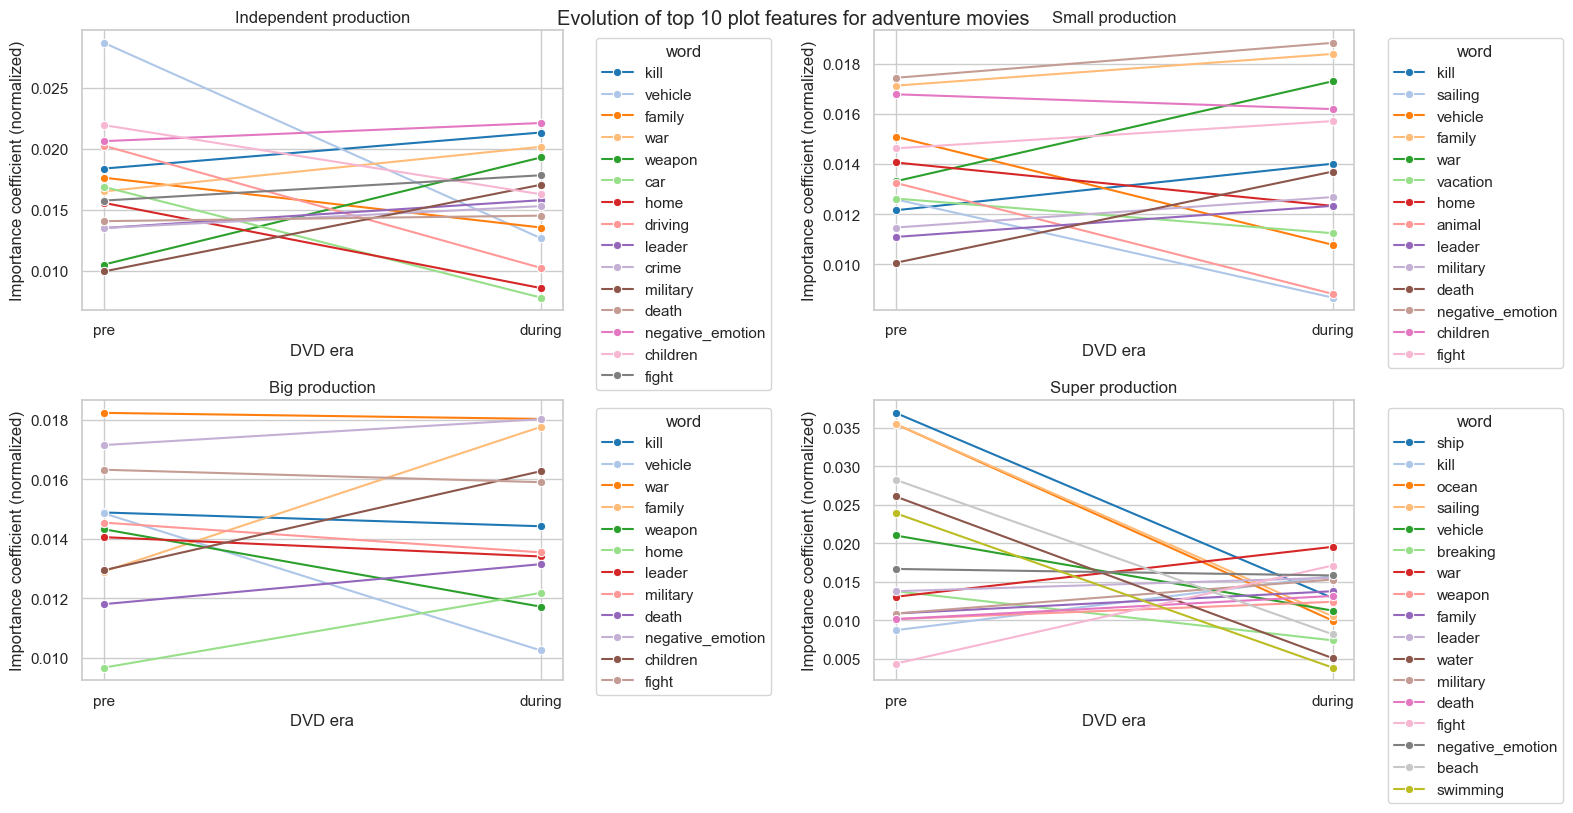

In [15]:
empathModel.plot_all_features(results, 'adventure')


# Production Countries 

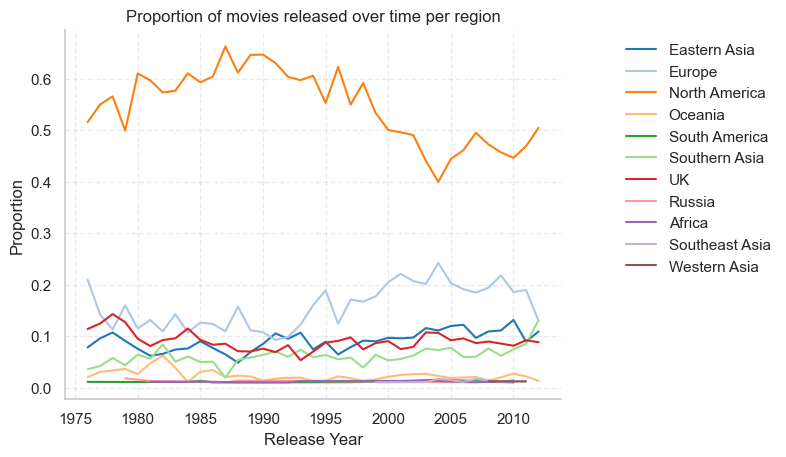

In [16]:
with open('./data/countries_to_region.json', 'r') as file:
    countries_regions = json.loads(file.read())
df_countries = df.copy().explode('production_countries')
df_countries = df_countries.explode('genres')
df_countries['region'] = df_countries.production_countries.apply(
    lambda x: countries_regions[x] if x in countries_regions and pd.notna(x) else None)
df_countries.dropna(subset=['region'], inplace=True)

region_props = get_proportions(df_countries, ['release_year'], 'region')
selected_regions = list(region_props[region_props.prop > 0.05].region.unique())
df_countries_filtered = df_countries[(df_countries.region.isin(selected_regions))
                                     & (df_countries.budget > 0)]

sns.lineplot(data=region_props[region_props.prop > 0.01], x='release_year', y='prop', hue='region', palette='tab20')
plt.legend(loc='upper right', bbox_to_anchor=(1.45, 1), frameon=False)
style_plot('Proportion of movies released over time per region', 'Release Year', 'Proportion')
plt.show()

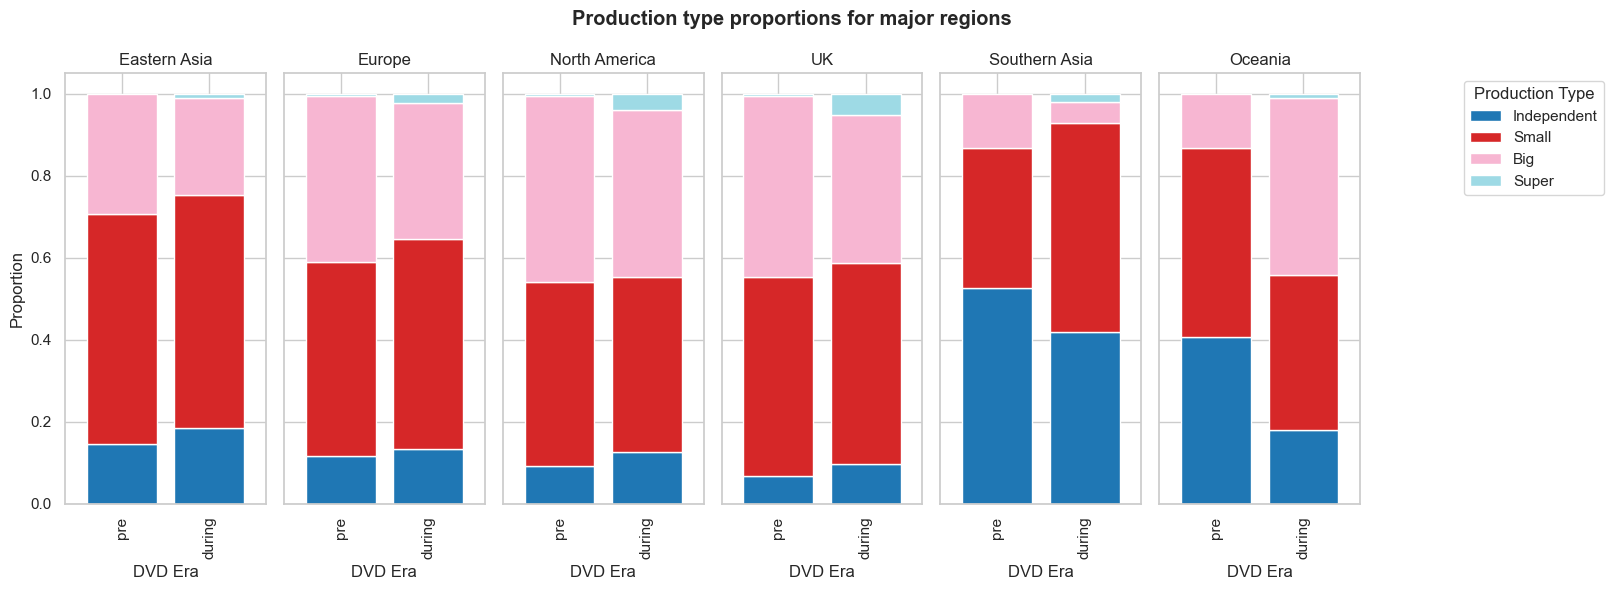

In [17]:
region_prod_props = get_proportions(df_countries_filtered, ['region','dvd_era'], 'prod_type')
f, axs = plt.subplots(1, len(selected_regions), figsize=(16, 6), sharey=True)

for i, region in enumerate(selected_regions):
    ax = axs[i]
    legend = False if (i < len(selected_regions) - 1) else True

    (region_prod_props[region_prod_props.region == region].
     pivot_table(index='dvd_era', columns='prod_type', values='prop', fill_value=0, observed=False)[
         ['Independent', 'Small', 'Big', 'Super']].
     plot(kind='bar', stacked=True, colormap='tab20', ax=ax, legend=legend, width=0.8))
    ax.set_title(region)
    ax.set_ylabel('Proportion')
    ax.set_xlabel('DVD Era')
sns.move_legend(axs[len(selected_regions) - 1], loc='upper right', bbox_to_anchor=(2.25, 1), title='Production Type')
f.suptitle('Production type proportions for major regions', fontweight='bold')
plt.tight_layout()
plt.show()

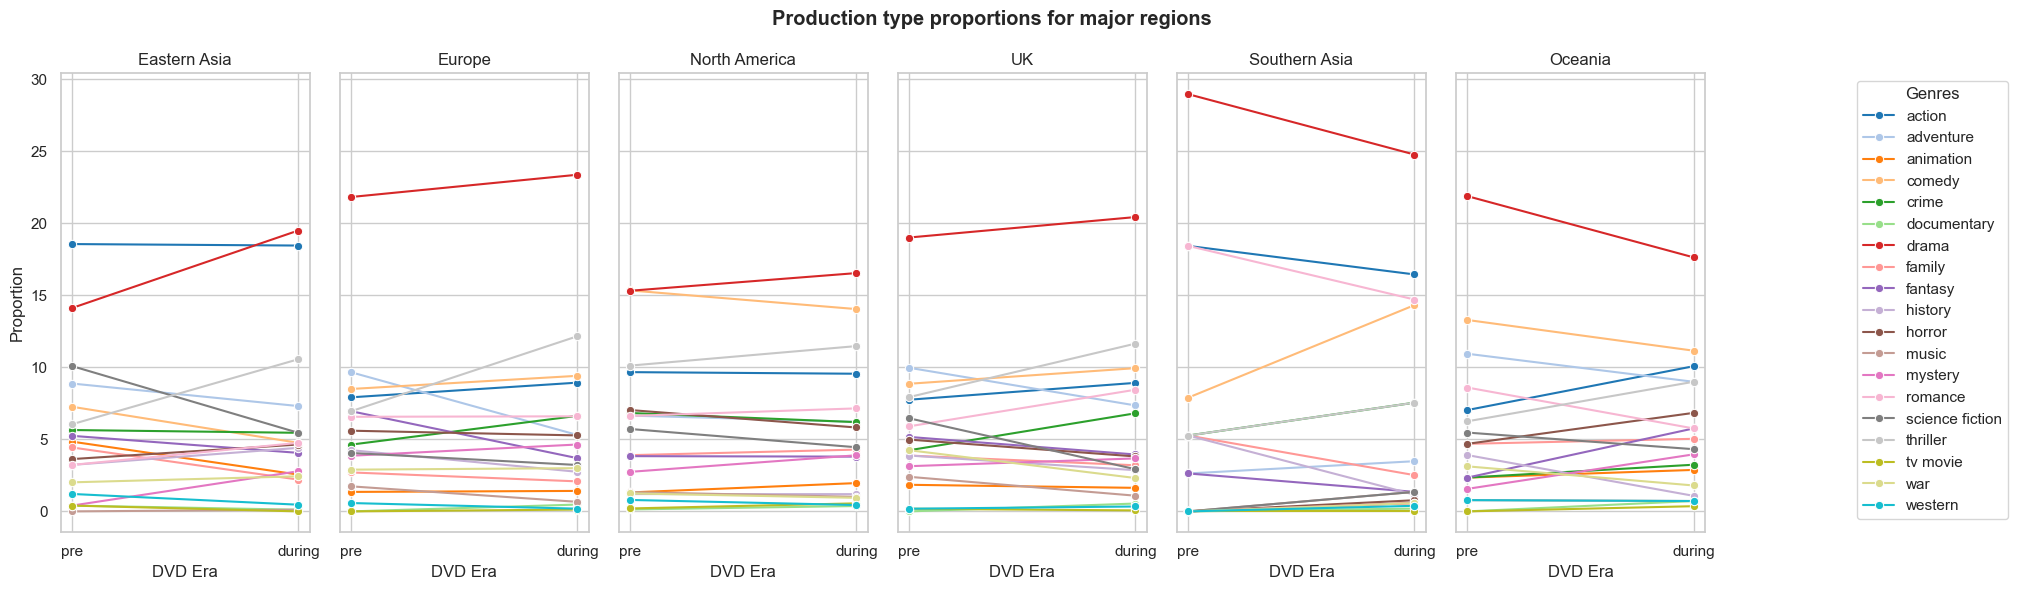

In [18]:
countries_genres_props = get_proportions(df_countries_filtered, ['dvd_era', 'region'], 'genres')
countries_genres_props.to_csv('data/website_data/CMU/region_genres_props.csv')
sns.set(style="whitegrid")
f, axs = plt.subplots(1, len(selected_regions), figsize=(20, 6), sharey=True)
# Loop through each production type
for i, region in enumerate(selected_regions):
    # Filter data for the current production type
    subset = countries_genres_props[countries_genres_props['region'] == region]
    subset.loc[:,'prop'] = subset['prop'].apply(lambda x : x*100)
    # Plot the evolution of proportions for genres across DVD eras
    ax = axs[i]
    legend = False if (i < len(selected_regions) - 1) else 'full'
    sns.lineplot(data=subset, x='dvd_era', y='prop', hue='genres', marker='o', ax=ax, legend=legend, palette='tab20')
    ax.set_ylabel('Proportion')
    ax.set_xlabel('DVD Era')
    ax.set_title(region)
        
sns.move_legend(axs[len(selected_regions)-1], loc='upper right', bbox_to_anchor=(2.25,1),title='Genres')
f.suptitle('Production type proportions for major regions', fontweight='bold')
plt.tight_layout()
plt.show()